In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

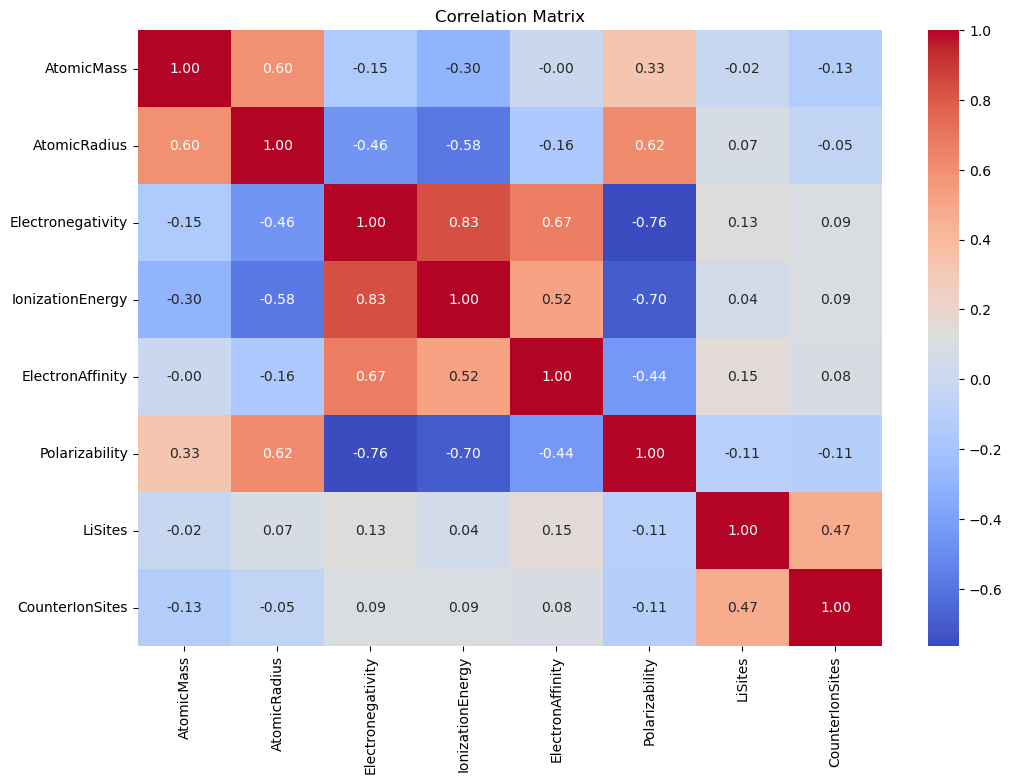

In [3]:
df = pd.read_csv('all_props.csv')

X = df.drop(columns=['results_per_li','results_per_total','Symbol','results_per_counter_ion'])

Y_total = df['results_per_total']
Y_li = df['results_per_li']


X.corr()

#plot X 

plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


#### reducing dimentinallity 

In [4]:
df.drop(columns=['Electronegativity','IonizationEnergy','AtomicMass','LiSites','CounterIonSites'], inplace=True)

X = df.drop(columns=['results_per_li','results_per_total','Symbol','results_per_counter_ion'])

In [5]:
df

,Symbol,AtomicRadius,ElectronAffinity,Polarizability,results_per_total,results_per_li,results_per_counter_ion
0,Ga,187.0,0.300,50.00,0.011710,0.011710,0.011710
1,Cu,140.0,1.228,46.50,0.014244,0.014244,0.014244
2,Ag,172.0,1.302,55.00,0.011542,0.011542,0.011542
3,Pd,202.0,0.557,26.14,0.015710,0.015710,0.015710
4,In,193.0,0.300,65.00,0.017291,0.017291,0.017291
...,...,...,...,...,...,...,...
447,Tl,196.0,0.200,66.00,0.010646,0.010646,0.010646
448,Pm,236.0,0.000,200.00,0.031452,0.031452,0.031452
449,Mg,173.0,0.000,71.20,0.010113,0.010113,0.010113
450,Pt,209.0,2.128,48.00,0.014012,0.014012,0.014012


In [6]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y_total, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Compute MAPE
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # MAPE in percentage

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Get feature importance (coefficients for linear regression)
features = X.columns  # Feature names
coefficients = model.coef_

# Combine into a dictionary
importance_dict = {feature: coef for feature, coef in zip(features, coefficients)}

# Sort by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print feature importances (coefficients)

i=0
print("\nFeature Importances (Coefficients):")
for feature, coef in sorted_importances:
    print(f"{feature}: {coef:.4f}")
    i+=1
    if i>10:
        break


Mean Absolute Percentage Error (MAPE): 92.55%

Feature Importances (Coefficients):
ElectronAffinity: -0.0021
Polarizability: 0.0001
AtomicRadius: -0.0000


#### Polynomial regression with grid search cv

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
import numpy as np

# Custom scorer for MAPE (lower is better)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y_total, test_size=0.2, random_state=42)

# Try different degrees
best_score = float('inf')
best_degree = None

for degree in range(1, 6):  # Trying degrees 1 to 5
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear', LinearRegression())
    ])
    # Negative because cross_val_score by default maximizes score
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=mape_scorer)
    avg_mape = -np.mean(scores) * 100  # Convert back to positive percentage

    print(f"Degree {degree}: Avg CV MAPE = {avg_mape:.2f}%")

    if avg_mape < best_score:
        best_score = avg_mape
        best_degree = degree

print(f"\nBest Degree: {best_degree} with Avg CV MAPE: {best_score:.2f}%")

# Train final model with best degree
final_poly = PolynomialFeatures(degree=best_degree, include_bias=False)
X_train_poly = final_poly.fit_transform(X_train)
X_test_poly = final_poly.transform(X_test)

final_model = LinearRegression()
final_model.fit(X_train_poly, y_train)

# Predict
y_pred = final_model.predict(X_test_poly)

# Compute final test MAPE
final_mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"\nFinal Test Mean Absolute Percentage Error (MAPE): {final_mape:.2f}%")

# Feature importance
features = final_poly.get_feature_names_out(X.columns)
coefficients = final_model.coef_

importance_dict = {feature: coef for feature, coef in zip(features, coefficients)}
sorted_importances = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print top 10 features
i = 0
print("\nFeature Importances (Coefficients):")
for feature, coef in sorted_importances:
    print(f"{feature}: {coef:.4f}")
    i += 1
    if i > 10:
        break


Degree 1: Avg CV MAPE = 153.56%
Degree 2: Avg CV MAPE = 140.90%
Degree 3: Avg CV MAPE = 136.17%
Degree 4: Avg CV MAPE = 145.44%
Degree 5: Avg CV MAPE = 150.60%

Best Degree: 3 with Avg CV MAPE: 136.17%

Final Test Mean Absolute Percentage Error (MAPE): 75.97%

Feature Importances (Coefficients):
ElectronAffinity: 0.0053
ElectronAffinity^2: 0.0030
Polarizability: 0.0008
ElectronAffinity^3: -0.0002
ElectronAffinity Polarizability: -0.0001
AtomicRadius ElectronAffinity: -0.0001
AtomicRadius: -0.0000
ElectronAffinity^2 Polarizability: 0.0000
AtomicRadius ElectronAffinity^2: -0.0000
Polarizability^2: -0.0000
AtomicRadius Polarizability: -0.0000


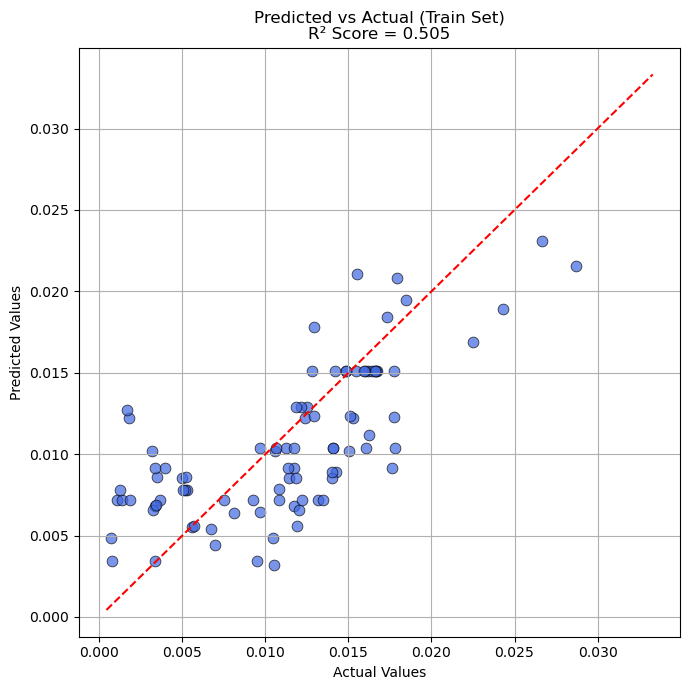

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# If you've already done model.predict(X_train)
y_test_pred = final_model.predict(X_test_poly)

# Plot actual vs predicted
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_test_pred, color='royalblue', s=60, edgecolor='black', alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # y = x line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Predicted vs Actual (Train Set)\nR² Score = {r2_score(y_test, y_test_pred):.3f}")
plt.grid(True)
plt.tight_layout()
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [17]:
# Get intercept (β0)
intercept = final_model.intercept_

# Get coefficients (β1, β2, ..., βn)
coefficients = final_model.coef_

# Get feature names from the PolynomialFeatures object
features = final_poly.get_feature_names_out(X.columns)  # Or from pipeline.named_steps['poly']

# Construct the equation
equation = f"y = {intercept:.4f}"
for feature, coef in zip(features, coefficients):
    equation += f" + ({coef:.4f} * {feature})"

print("Regression Equation:")
print(equation)

Regression Equation:
y = 0.0042 + (-0.0000 * AtomicRadius) + (0.0053 * ElectronAffinity) + (0.0008 * Polarizability) + (-0.0000 * AtomicRadius^2) + (-0.0001 * AtomicRadius ElectronAffinity) + (-0.0000 * AtomicRadius Polarizability) + (0.0030 * ElectronAffinity^2) + (-0.0001 * ElectronAffinity Polarizability) + (-0.0000 * Polarizability^2) + (0.0000 * AtomicRadius^3) + (0.0000 * AtomicRadius^2 ElectronAffinity) + (-0.0000 * AtomicRadius^2 Polarizability) + (-0.0000 * AtomicRadius ElectronAffinity^2) + (0.0000 * AtomicRadius ElectronAffinity Polarizability) + (0.0000 * AtomicRadius Polarizability^2) + (-0.0002 * ElectronAffinity^3) + (0.0000 * ElectronAffinity^2 Polarizability) + (-0.0000 * ElectronAffinity Polarizability^2) + (-0.0000 * Polarizability^3)
